XGBoost Accuracy: 0.7014613778705637
Classification Report:
              precision    recall  f1-score   support

           A       0.44      0.19      0.27        21
           B       0.58      0.56      0.57        54
           C       0.50      0.59      0.54        78
           D       0.45      0.46      0.45        83
           F       0.90      0.90      0.90       243

    accuracy                           0.70       479
   macro avg       0.57      0.54      0.55       479
weighted avg       0.70      0.70      0.70       479



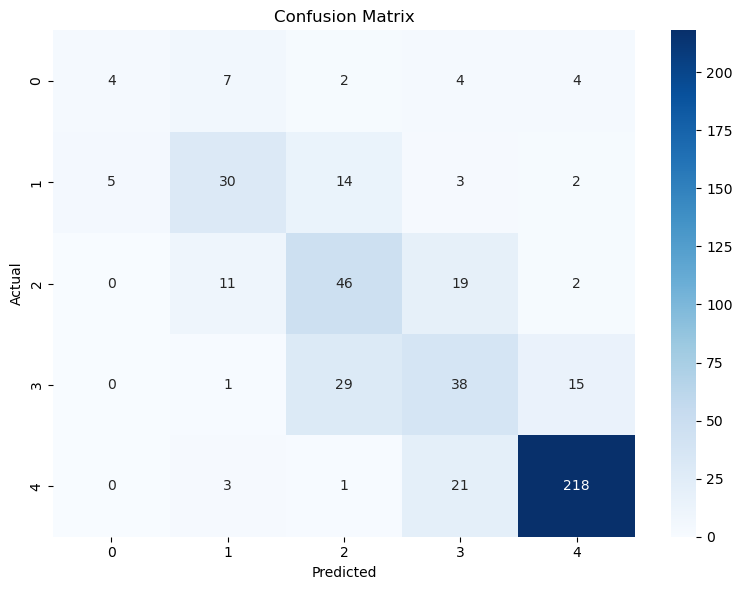

First 20 Predictions:


,Actual,Predicted,Match
0,4.000000,4,True
1,4.000000,4,True
2,4.000000,4,True
3,4.000000,4,True
4,2.000000,1,False
5,3.000000,3,True
6,2.000000,1,False
7,4.000000,3,False
8,4.000000,4,True
9,3.000000,4,False


Predicted Grade: C ,for given student input


C:\Users\oosun\AppData\Local\Temp\ipykernel_14700\394263768.py:117: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df_input = df_input.apply(pd.to_numeric, errors='ignore')  # Cast numerics properly


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

#Step 1: Import CSVs
df_train = pd.read_csv('../data/train_data.csv', delimiter=",")
df_test = pd.read_csv('../data/test_data.csv', delimiter=",")

#Step 2: Separate features and target
X_train = df_train.drop(columns=["StudentID", "GradeClass", "GPA"])
y_train = df_train['GradeClass']

X_test = df_test.drop(columns=["StudentID", "GradeClass", "GPA"])
y_test = df_test['GradeClass']

#Step 3: Build a pipeline of training
pipeline = Pipeline(steps=[
    ('clf', XGBClassifier(eval_metric='mlogloss', random_state=47))
])

#Step 4: Set up hyperparameter tuning
from skopt import BayesSearchCV
from skopt.space import Real, Integer

search_space = {
    'clf__max_depth' : Integer(2,8),
    'clf__learning_rate' : Real(0.001, 1.0, prior='log-uniform'),
    'clf__subsample' : Real(0.5, 1.0),
    'clf__colsample_bytree' : Real(0.5, 1.0),
    'clf__colsample_bylevel' : Real(0.5, 1.0),
    'clf__colsample_bynode' : Real(0.5, 1.0),
    'clf__reg_alpha' : Real(0.0, 10.0),
    'clf__reg_lambda' : Real(0.0, 10.0),
    'clf__gamma' : Real(0.0, 10.0)
}

#Step 5: Training the XGBoost model
opt = BayesSearchCV(pipeline, search_space, cv=5, n_iter=100, scoring='accuracy', random_state=47)

opt.fit(X_train, y_train)

#Evaluate best parameters
opt.best_estimator_
opt.best_score_
opt.score(X_test, y_test)
opt.predict(X_test)
opt.predict_proba(X_test)

#Step 6: Save the model as pkl file in artifacts
with open("../artifacts/xgboost_model.pkl", "wb") as file:
   pickle.dump(opt.best_estimator_, file)

#Step 7: Make predictions
predictions = opt.predict(X_test)

#Step 8: Evaluation
accuracy = accuracy_score(y_test, predictions)
print("XGBoost Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, predictions, target_names=["A", "B", "C", "D", "F"]))

#Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

#Step 9: Show and save the predictions table
try:
    from IPython.display import display

    # Prepare DataFrame for display
    comp_df = pd.DataFrame({"Actual": y_test.values,"Predicted": predictions})
    comp_df["Match"] = comp_df["Actual"] == comp_df["Predicted"]

    def highlight_false_text(row):
        styles = []
        for col in row.index:
            if col == "Match" and row["Match"] == False:
                styles.append("color: red; background-color: black")
            else:
                styles.append("background-color: black; color: white")
        return styles

    print("First 20 Predictions:")
    display(comp_df.head(20).style.apply(highlight_false_text, axis=1))

except Exception as e:
    print("\n First 20 Predictions:")
    print(comp_df.head(20).to_string(index=False))

#Step 10: Save predictions to CSV
comp_df = X_test.copy()
comp_df["Actual_GradeClass"] = y_test.values
comp_df["Predicted_GradeClass"] = predictions
comp_df.to_csv("../data/xgboost_prediction.csv", index=False)

#Prediction function for the given input test
def predict_student_grade(input_string):
    columns = ["Age", "Gender", "Ethnicity", "ParentalEducation", "StudyTimeWeekly", "Absences", "Tutoring", "ParentalSupport", "Extracurricular","Sports", "Music", "Volunteering"]

    # Convert input string into a list
    input_data = input_string.split(",")

    # Automatically remove the first value (StudentID) and last two values (GPA & GradeClass)
    input_data = input_data[1:-2] # Removes 1 from start and last 2 items

    # Create DataFrame from input
    df_input = pd.DataFrame([input_data], columns=columns)
    df_input = df_input.apply(pd.to_numeric, errors='ignore')  # Cast numerics properly

    # Predict using the loaded model
    prediction = opt.predict(df_input)
    
    #Mapping numeric class baack to the letter grade
    grade_map = {0: "A", 1: "B", 2: "C", 3: "D", 4: "F"}

    predicted_grade = grade_map[prediction[0]] 

    return predicted_grade

#Step 11: Example testing input from the csv file
student_input = "1015,18,1,0,1,11.197810636915708,9,1,2,0,0,0,0,2.396788117124796,3.0"

#Print predicted grade
print(f"Predicted Grade: {predict_student_grade(student_input)} ,for given student input")

